# Tutorial for generating reliability field maps and gradient flow vectors:

## Reliability Field maps:  
Field maps show the contribution of the intra (x-axis) and inter (y-axis) variation to the ICC in a two dimensional histogram.

The field maps can be created using any measurable variable, but we focus on edges from a functional connectivity matrix. For a given edge, we plot the intra- and inter-variation on the x- and y-axis respectively revealing ICC (intra- and between-variation) via diagonal lines originating from point 0,0 in a rainbow-like manner. 

## Gradient flow vectors:
Built upon the variability field map, we also utilize the variability gradient flow map (GFM) for assessing the relative impact of reliability optimizations focused on one form of variation versus the other, depending on the current balance of the intra- and inter-individual variations. This allows us to identify how and where the difference in variability between two conditions changes in an optimal or sub-optimal direction towards the highest 

The gradient vector on the field map represents the optimal direction for maximal ICC change on the respective axes of individual variability. For a given ICC change, we normalized its gradient by the contributions of individual variability as compared to the optimal direction

## Data used:
 * Functional
     * N<sub>subs</sub> x edges from upper triangle of functional connectivity matrix
 * Behavioral
     * N<sub>subs</sub> x 68 behavioral measures “Cognition”, “Emotion”, “Personality” (check “Motor” and “Sensory”)

## Generating reliability field maps:
 * For this tutorial we compare functional connectivity from data processed with GSR and without GSR.
 * After importing libraries we load in results generated from our relibility model, most importantly ICC, raw intra-individual variation, raw inter-individual variation which we will use for both reliability field maps and gradient flow maps.
 * We will first create individual field maps with the function **field_map()**.
 * Overlaying the individual field maps with just the contour lines allows visual comparison of inter- and intra-individual variation on ICC (**field_map_overlay()**).
 
## Generating gradient flow vector angular histograms:
 * Gradient flow histograms are created using **gradient_flow_histogram()**.
     * 1. intra- and inter-individual variation is used to calculate standardized gradient flow vectors and the count for each angle is plotted.
     * 2. Each angle is counted and the total number is plotted according to the gradient flow circular colormap.
 
## Generating surface plots for ICC differences and parcel-wise gradient flow vectors:
 * Mean of ICC differences and mean gradient flow vector direction for each parcel connectivity vector (row/column of ICC/gradient flow matrix) are plotted on the cortical surface with **plot_surface()** .
 * **calc_icc_vectors_mean()** first calculates standardized gradient flow vectors using the parcel vector mean of inter- and intra-individual differences to yield mean gradient flow vector direction for each parcel.
     * Separate surface plots are generated for positive and negative ICC difference and gradient flow direction for clarity.
     * Due to averaging across the parcel connectivity vector, ICC difference and gradient flow direction might not have complete congruency. 

#### Import functions needed for field maps and gradient flow vectors

In [43]:
%matplotlib inline
import os,sys
import cifti
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import surface,plotting
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('../code')
from gradient_flow_vectors import *
from reliability_field_maps import *
from variability_utils import *

#### Load surfaces to plot ICC differences and gradient flow vectors on the surface

In [2]:
# Conte surface
lsurf = surface.load_surf_mesh('../misc/surfaces/Conte69.L.very_inflated.10k_fs_LR.surf.gii')
rsurf = surface.load_surf_mesh('../misc/surfaces/Conte69.R.very_inflated.10k_fs_LR.surf.gii')

# Surface plot background
bg = nib.load('../misc/surfaces/100206.sulc.10k_fs_LR.dscalar.nii').get_fdata()

# Example file to save surface plots
plabel = '../misc/Glasser2016_labels/HCP_MMP_P210_10k.dlabel.nii'
glasserlabel,(ax1,ax2) = cifti.read(plabel)
numverts = glasserlabel.shape[1]

#### Load colormaps and set gradient flow vector options:

In [3]:
# Colormaps
rvb = vector_cmap() # Gradient flow vector colormap
yeo_colors = get_yeo_colors() # Yeo 7 network colors in RGB
allparcels = get_yeo_parcels() # Glasser 360 parcels to Yeo 7 network assignments

# Set colormaps/colors for field map contours
taskcolors = {'2subsets_1200TRx1seg_REST1_LR_gsr':'grey',
 '2subsets_1200TRx1seg_REST1_LR_nogsr':'red'}
taskcmaps = {'2subsets_1200TRx1seg_REST1_LR_gsr':'Greys',
 '2subsets_1200TRx1seg_REST1_LR_nogsr':'Reds'}

# Vector plot options:
outpath = False
vector_type = 'norm_0' # raw, norm, norm_0
alpha = 1 # plot option
# savefolder = '../figures'

#### Load GSR vs no GSR data as dictionary:
 * ICC
 * raw intra-individual variation
 * raw inter-individual variation
 * total variation
 * mask of failed edges
 * ICC Input

In [46]:
# Load Data:
tasks = ['2subsets_1200TRx1seg_REST1_LR_nogsr','2subsets_1200TRx1seg_REST1_LR_gsr']
data = load_data(tasks)

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


## 1. Individual fieldmaps for GSR and no GSR

2subsets_1200TRx1seg_REST1_LR_nogsr


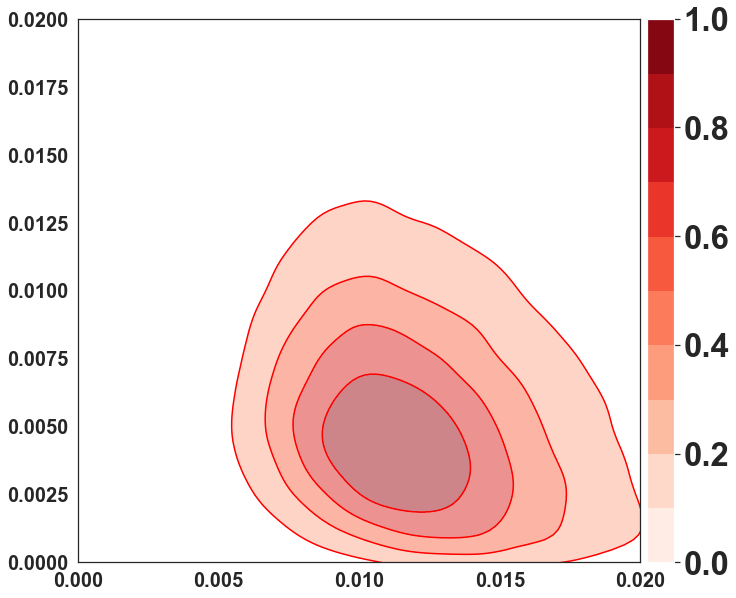

2subsets_1200TRx1seg_REST1_LR_gsr


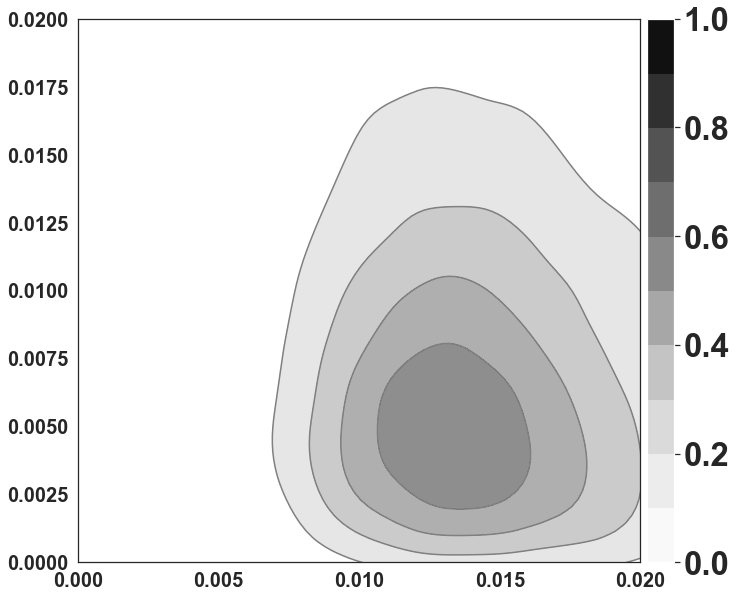

In [23]:
from reliability_field_maps import single_fieldmap

contourcolors = taskcolors.copy()
network_xy = {}
alignment = ''
percnum = 0
lines = True
outpath = False

for cond1 in tasks:
    print(cond1)
    t1color = taskcolors[cond1]
    exec('colors1 = plt.cm.%s(np.linspace(0,1,128))' % taskcmaps[cond1])
    cond1w = data[cond1]['raww'].copy()
    cond1b = data[cond1]['rawb'].copy()
    wmask1 = np.where((cond1w != 0) & (cond1w <= 0.015))[0]
    bmask1 = np.where((cond1b != 0) & (cond1b <= 0.015))[0]
    cond1totmask = np.intersect1d(bmask1,wmask1)

    # Mask b/w and w/in values for each condition
#     bothmask = np.intersect1d(cond1totmask,cond2totmask)
    bothmask = np.intersect1d(data[cond1]['totmask'],data[cond1]['totmask'])
    cond1w = cond1w[bothmask]
    cond1b = cond1b[bothmask]
    
    # Setting to top X percentile
    perc = np.percentile(data[cond1]['icc'][bothmask],percnum)
    percmask = np.where(data[cond1]['icc'][bothmask]>perc)[0]
    cond1w = cond1w[percmask]
    cond1b = cond1b[percmask]
    single_fieldmap(cond1w,cond1b,t1color,taskcmaps,outpath,lines)

## 2. Field map overlap for GSR and no GSR

In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde
import matplotlib.pyplot as pltd
from reliability_field_maps import _bivariate_kdeplot 
from reliability_field_maps import _scipy_bivariate_kde 
network_xy = {}
alignment = ''
percnum = 0

for taskcombo in [['2subsets_1200TRx1seg_REST1_LR_nogsr','2subsets_1200TRx1seg_REST1_LR_gsr']]:
    plt.figure(figsize=(10,10))
    sns.set_style('white')
    ax=plt.gca()
    mpl.rcParams['font.weight'] = 'bold'
    mpl.rcParams['font.size'] = 1
    sns.set(font_scale=3)
    ax.axes.set_xlim([0,0.025])
    ax.axes.set_ylim([0,0.025])
    #     ax.axes.set_xlim([0,0.1])
    #     ax.axes.set_ylim([0,0.1])
    plt.xticks(fontweight='bold',fontsize=20)
    plt.yticks(fontweight='bold',fontsize=20)
    ###

    for cond1 in taskcombo:
        print(cond1)
        t1color = taskcolors[cond1]
        exec('colors1 = plt.cm.%s(np.linspace(0,1,128))' % taskcmaps[cond1])
        cond1w = data[cond1]['raww'].copy()
        cond1b = data[cond1]['rawb'].copy()
        wmask1 = np.where((cond1w != 0) & (cond1w <= 0.015))[0]
        bmask1 = np.where((cond1b != 0) & (cond1b <= 0.015))[0]
        cond1totmask = np.intersect1d(bmask1,wmask1)

        # Mask b/w and w/in values for each condition
    #     bothmask = np.intersect1d(cond1totmask,cond2totmask)
        bothmask = np.intersect1d(data[cond1]['totmask'],data[cond1]['totmask'])
        cond1w = cond1w[bothmask]
        cond1b = cond1b[bothmask]

        # Setting to top X percentile
        perc = np.percentile(data[cond1]['icc'][bothmask],percnum)
        percmask = np.where(data[cond1]['icc'][bothmask]>perc)[0]
        cond1w = cond1w[percmask]
        cond1b = cond1b[percmask]
        #### Edit end:

        bw='scott'
        gridsize=300
        cut=10
        clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
        shade=True
        filled=True
        fill_lowest=False
        xx1, yy1, z1 = _scipy_bivariate_kde(cond1w, cond1b, bw, gridsize, cut, clip)
        scaler = float(1000)
        z1scale = scaler*z1/np.sum(z1)
        normalized = (z1scale-np.min(z1scale))/(np.max(z1scale)-np.min(z1scale))
        shade=False
        vertical=False
        kernel="gau",
        bw="scott"
        gridsize=300
        cut=10
        clip=None
        legend=True
        cumulative=False
        shade_lowest=False
    #     cbar=True
        cbar=False
        cbar_ax=None
        cbar_kws={'cmap':taskcmaps[cond1]}
        our_cmap = plt.get_cmap(taskcmaps[cond1])
        if alignment == '':
            cmap_max = 1.01# was 60
        else:
            cmap_max = 1.01
        norm = mcolors.Normalize(vmin=0, vmax=cmap_max)    
        proxy_mappable = mpl.cm.ScalarMappable(cmap=our_cmap, norm=norm)
        proxy_mappable.set_array(normalized)   

    #     sns.set_style('white')    
    #     ax = _bivariate_kdeplot(xx1, yy1, normalized, shade, shade_lowest, kernel, bw, gridsize, cut, clip, legend, cbar, cbar_ax, cbar_kws, ax,vmin=0,vmax=cmap_max,levels=np.arange(0,cmap_max+.5,0.25))
        if cond1 == '2subsets_1200TRx1seg_REST1_LR_nogsr':
            alpha = 0.7
        else:
            alpha = 0.7
        ax = _bivariate_kdeplot(xx1, yy1, normalized, shade, 
                                shade_lowest, kernel, bw, gridsize, 
                                cut, clip, legend, cbar, cbar_ax, cbar_kws, 
                                ax,vmin=0,vmax=cmap_max,levels=5,alpha=1,
                               linewidths=5)
#         ax.contour(xx1,yy1,normalized,5, colors = contourcolors[cond1],alpha=0.5)
    ax.plot([1,0],[1,0],color='black',alpha=0.3)
    for iccline in [0.2,0.4,0.6,0.8]:
        ax.plot([1,0],[iccline,0],color='black',alpha=0.3)
        ax.plot([iccline,0],[1,0],color='black',alpha=0.3)    
#     plt.colorbar(proxy_mappable, boundaries=np.arange(0,cmap_max,.1), spacing='proportional', orientation='vertical', pad=.01)
#     plt.savefig('../figures/shortpaper/fieldmaps/%s_%s_perc%s_fieldmap_nogsr_front_contour_070121_time_1200-600.png' % (taskcombo[0],taskcombo[1],percnum),dpi=300)
    plt.show()

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


2subsets_1200TRx1seg_REST1_LR_nogsr


NameError: name 'string_types' is not defined

## Gradient flow vector angular histogram:

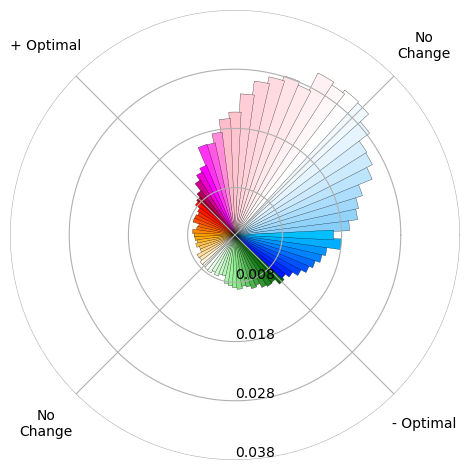

In [61]:
# All Edges:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Vector plot options:
outpath = False
vector_type = 'norm_0' # raw, norm, norm_0
alpha = 1 # plot option
vector_type = 'norm_0'
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
alpha = 1
tasks = ['2subsets_1200TRx1seg_REST1_LR_nogsr','2subsets_1200TRx1seg_REST1_LR_gsr']
for ind1,task0 in enumerate(tasks):
    for ind2,task1 in enumerate(tasks[ind1+1:len(tasks)]):
        cond0 = task0
        cond1 = task1
        task0name = '%s' % (cond0)
        task1name = '%s' % (cond1)

        # Check if this can be shortened:
        # Read in data:
        icc1 = data[cond1]['icc'].astype(float)[:64620]
        icc0 = data[cond0]['icc'].astype(float)[:64620]
        x1 = data[cond1]['raww'].astype(float)[:64620]
        x0 = data[cond0]['raww'].astype(float)[:64620]
        y1 = data[cond1]['rawb'].astype(float)[:64620]
        y0 = data[cond0]['rawb'].astype(float)[:64620]

        # Parcel-wise so create matrices and masks
        maticc1,icc1mask = array2mat(icc1,360)
        maticc0,icc0mask = array2mat(icc0,360)
        matx1,matx1mask = array2mat(x1,360)
        matx0,matx0mask = array2mat(x0,360)
        maty1,maty1mask = array2mat(y1,360)
        maty0,maty0mask = array2mat(y0,360)

        # Mask containing good edges for both conditions
        finalmask = icc0mask*icc1mask*matx1mask*matx0mask*maty1mask*maty0mask
        maticc1 = maticc1*finalmask
        maticc0 = maticc0*finalmask
        matx1 = matx1*finalmask
        matx0 = matx0*finalmask
        maty1 = maty1*finalmask
        maty0 = maty0*finalmask

        # All upper triangle edges:
        netx0 = matx0[np.triu_indices(360,1)].flatten()
        nety0 = maty0[np.triu_indices(360,1)].flatten()
        netx1 = matx1[np.triu_indices(360,1)].flatten()
        nety1 = maty1[np.triu_indices(360,1)].flatten()
        neticc0 = maticc0[np.triu_indices(360,1)].flatten()
        neticc1 = maticc1[np.triu_indices(360,1)].flatten()

        # Calculate vector parameterss
        df = calc_icc_vectors(np.array(netx0),np.array(nety0),np.array(netx1),np.array(nety1),
                              np.array(neticc0),np.array(neticc1),task0name,task1name)
        theta = ang2deg(df)[0]
        theta = theta[~np.isnan(theta)]
        # Setting bins:
        bins = np.arange(0,361,5)
        a = np.histogram(theta,bins)
        # Set frequency:
        height = a[0]/np.sum(a[0])
        deg_ind = np.radians(a[1][1:])
        width = .1
        rmax = np.nanmax(height)
        # color list:
        rvbColors = colors = rvb(np.linspace(0, 1, len(deg_ind)))
        # Plot angular histo:
        ax = plt.subplot(111, projection='polar')
        ax.set_rlim(0, rmax)
        ax.set_rticks(np.round(np.arange(rmax/4., rmax+0.01, rmax/3.),3))
        ax.set_rlabel_position(-90)
#         ax.bar(x=deg_ind, height=height, width=width, 
#                bottom=0, alpha=0.5, color = taskcolors[cond1], edgecolor = 'dimgray')
        ax.bar(x=deg_ind, height=height, width=width, 
               bottom=0, alpha=1, color = rvbColors, edgecolor = 'black',lw=0.2)
        ax.bar(x=np.radians([45,135,225,315]), height=10, width=0, 
               bottom=0, alpha=1, tick_label=['No\nChange','+ Optimal','No\nChange','- Optimal'], 
               color = 'k',zorder=0)
        ax.tick_params(axis='both', which='major', pad=20, color = 'k')
        ax.spines['polar'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10)
#         plt.title('' % (cond1.split('_')[2],cond0.split('_')[2]),pad=10)
        plt.tight_layout()
        plt.show()


In [82]:
_scipy_bivariate_kde?

## GSR vs No GSR surface

In [62]:
def plot_surface(vdata,lsurf,rsurf,data_range,cmap,alpha,darkness,symmetric_cmap,outpath,plotname):
    vmin,vmax = data_range
    for side in ['left','right']:
        if side == 'left':
            surf_array = vdata[0,:10242]
            surf = lsurf
        else:
            surf_array = vdata[0,10242:]
            surf = rsurf
        for view in ['lateral','medial']:
            plt.figure(figsize=(10,15))
            plt.rcParams['axes.facecolor'] = 'white'
            _ = plotting.plot_surf(surf, surf_array, 
                                   hemi=side, view=view,
                                   bg_on_data = True,
                                   cmap = cmap, colorbar=True, vmin=vmin, vmax=vmax, 
                                   avg_method='median',alpha=alpha, darkness=darkness,
                                   symmetric_cmap=symmetric_cmap)
#             if outpath:
#                 plt.savefig('%s/%s_%s_%s.png' % (outpath,plotname,side,view),dpi=300)
#             plt.close()
def parcel2vert(glasserlabel,theta_img):
    numverts = glasserlabel.shape[1]
    if len(theta_img.shape) >1:
        numparcels = len(theta_img)
    else:
        numparcels = 1
        theta_img = np.reshape(theta_img,[-1,len(theta_img)])
    nparc = np.arange(numparcels)
    data = np.zeros([numparcels,numverts])
    for parcel in nparc:
        for plabel in range(int(np.max((glasserlabel)))):
            p_idx = np.where(glasserlabel[0,:]==plabel+1)[0]
            data[parcel,p_idx] = theta_img[parcel,plabel]
    return data

In [63]:
taskcombos = [['2subsets_1200TRx1seg_REST1_LR_nogsr','2subsets_1200TRx1seg_REST1_LR_gsr']]
outpath = '../figures/shortpaper/shortpaper_new/concat_vs_contiguous/surface'
numparcels = 1
alpha = 1
examplecifti = glasserlabel,(ax1,ax2) = cifti.read(plabel)

for taskcombo in taskcombos:
    for posNeg in ['positive','negative']:
        task1 = taskcombo[0]
        task2 = taskcombo[1]
        # Vector angles:
        mask1 = data[task1]['totmask']
        mask2 = data[task2]['totmask']
        bothMask = np.intersect1d(mask1,mask2)
        icc0 = array2mat(data[task1]['icc'],447)[0]#[bothMask]
        icc1 = array2mat(data[task2]['icc'],447)[0]#[bothMask]
        x0 = array2mat(data[task1]['raww'],447)[0]#[bothMask]
        y0 = array2mat(data[task1]['rawb'],447)[0]#[bothMask]
        x1 = array2mat(data[task2]['raww'],447)[0]#[bothMask]
        y1 = array2mat(data[task2]['rawb'],447)[0]#[bothMask]
        df = calc_icc_vectors_mean(x0,y0,x1,y1,icc0,icc1,task1,task2)
        plotname =  '%s-%s_%s_vectors' % (task2,task1,posNeg)

        # plot options:
        numparcels = 1
        alpha = 1
        darkness = 0.1
        data_range = (0,360)
        symmetric_cmap = False
        cmap = rvb
        angVerts = parcel2vert(glasserlabel,ang2deg(df))
        posNegMask = parcel2vert(glasserlabel,icc1-icc0)
        meandICC = np.mean(posNegMask,0)
    #         if posNeg == 'positive':
    #             posNegMask[posNegMask<0] = 0
    #         else:
    #             posNegMask[posNegMask>0] = 0
        if posNeg == 'negative':
            angVerts[(angVerts>=45) & (angVerts<=225)] = 45
            angVerts[angVerts==0] = 45
            meandICC[meandICC> 0]  = 0
        elif posNeg == 'positive':
            angVerts[angVerts>=225] = 45
            angVerts[angVerts<=45] = 45
            angVerts[angVerts==0] = 45
            angVerts[np.isnan(angVerts)] = 45
            meandICC[meandICC< 0]  = 0
    #         angVerts[0,np.logical_not(mask10k[0].astype(bool))] = 45
    #         angVerts[0,posNegMask.astype(bool)] = 45
    
        # Plot angles:
        plot_surface(angVerts,lsurf,rsurf,data_range,cmap,alpha,darkness,symmetric_cmap,outpath,'%s-%s_%s_dICC_angle' % (task2,task1,posNeg))
        
        # ICC Diff:
        examplecifti, (ax1,ax2) = cifti.read('/Users/jaewook.cho/Documents/resources/10k/100206.sulc.10k_fs_LR.dscalar.nii')
        examplecifti = np.reshape(np.mean(posNegMask,0),[1,posNegMask.shape[1]])
        plot_surface(np.reshape(meandICC,[1,posNegMask.shape[1]]),lsurf,rsurf,(-.2,.2),'bwr',alpha,darkness,True,outpath,'%s-%s_%s_iccDiff_070121' % (task2,task1,posNeg))
#         cifti.write('%s/%s-%s_iccDiff_070121.dscalar.nii' % (outpath,task2,task1),examplecifti,[ax1,ax2])



../code/gradient_flow_vectors.py:102: RuntimeWarning: invalid value encountered in true_divide
  angle0 = np.arctan(y0/x0)
/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/anaconda2/envs/py36/lib/python3.6/site-packages/nilearn/plotting/surf_plotting.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figsize=figsize)


In [68]:
df = calc_icc_vectors_mean(x0,y0,x1,y1,icc0,icc1,task1,task2)
ang2deg(df).shape

(1, 447)

(1, 447)